# Specific Test II. Lens Finding

Task: Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
import os
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.11.0


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))

Found GPU at /device:GPU:0


In [3]:
path = '/kaggle/input/lens-finding/SpaceBasedTraining/classifications.csv'
lis = pd.read_csv(path)

# Analyzing Csv Data

In [4]:
lis

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.4290
1,100001,1,1.317890e-10,294,855.5890
2,100002,1,4.877250e-12,140,486.1130
3,100003,1,1.440160e-09,1500,10467.4000
4,100004,0,2.197350e-11,0,0.0000
...,...,...,...,...,...
17995,117995,1,4.428430e-11,35,68.9357
17996,117996,0,1.937930e-11,0,0.0000
17997,117997,1,5.505060e-11,520,1145.4500
17998,117998,1,9.624780e-12,109,434.6310


# Analysing images

In [5]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

In [6]:
image_file = get_pkg_data_filename('/kaggle/input/lens-finding/SpaceBasedTraining/files/imageEUC_VIS-100004.fits')

In [7]:
fits.info(image_file)

Filename: /kaggle/input/lens-finding/SpaceBasedTraining/files/imageEUC_VIS-100004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   


In [8]:
image_data = fits.getdata(image_file, ext=0)

In [9]:
image_data = np.asarray(image_data)
image_data /= image_data.max()
image_data = np.abs(image_data)
print(image_data.min())

1.06779055e-07


In [10]:
# print(image_data)
img = image_data
def modify(image):
    image = image.reshape((101,101,1))
    img = tf.reshape(tf.broadcast_to(image, (101, 101, 3)),  (101, 101, 3))
#     img = tf.image.resize(np.array(img),[224,224])
    return img
image_data = modify(image_data)

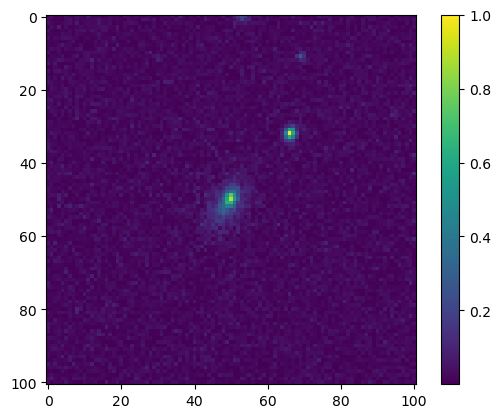

In [11]:
plt.figure()
plt.imshow(img)
plt.colorbar()

In [12]:
lis.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,18000.0,1.089995e+05,5.196297e+03,1.000000e+05,1.044998e+05,1.089995e+05,1.134992e+05,1.179990e+05
is_lens,18000.0,6.985556e-01,4.588980e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Einstein_area,18000.0,3.173590e-10,4.875041e-10,1.686280e-12,6.615410e-12,5.141860e-11,4.463070e-10,1.883010e-09
numb_pix_lensed_image,18000.0,3.306931e+02,5.808092e+02,0.000000e+00,0.000000e+00,1.140000e+02,3.870000e+02,7.558000e+03
flux_lensed_image_in_sigma,18000.0,2.402448e+03,1.460743e+04,0.000000e+00,0.000000e+00,3.500205e+02,1.462402e+03,8.829000e+05


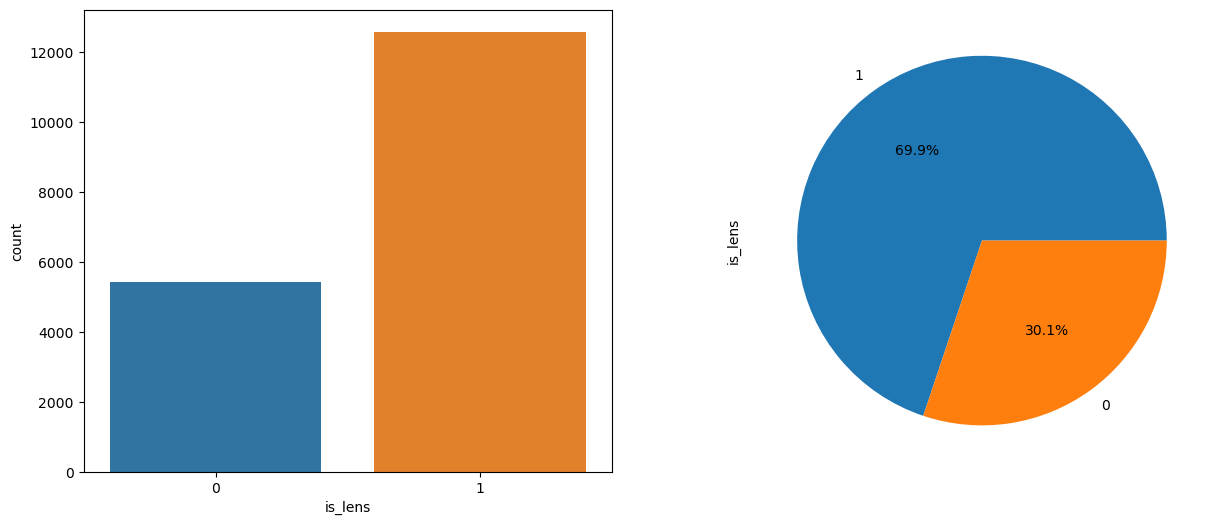

In [13]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='is_lens', data=lis, ax=ax[0])
_ = lis['is_lens'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

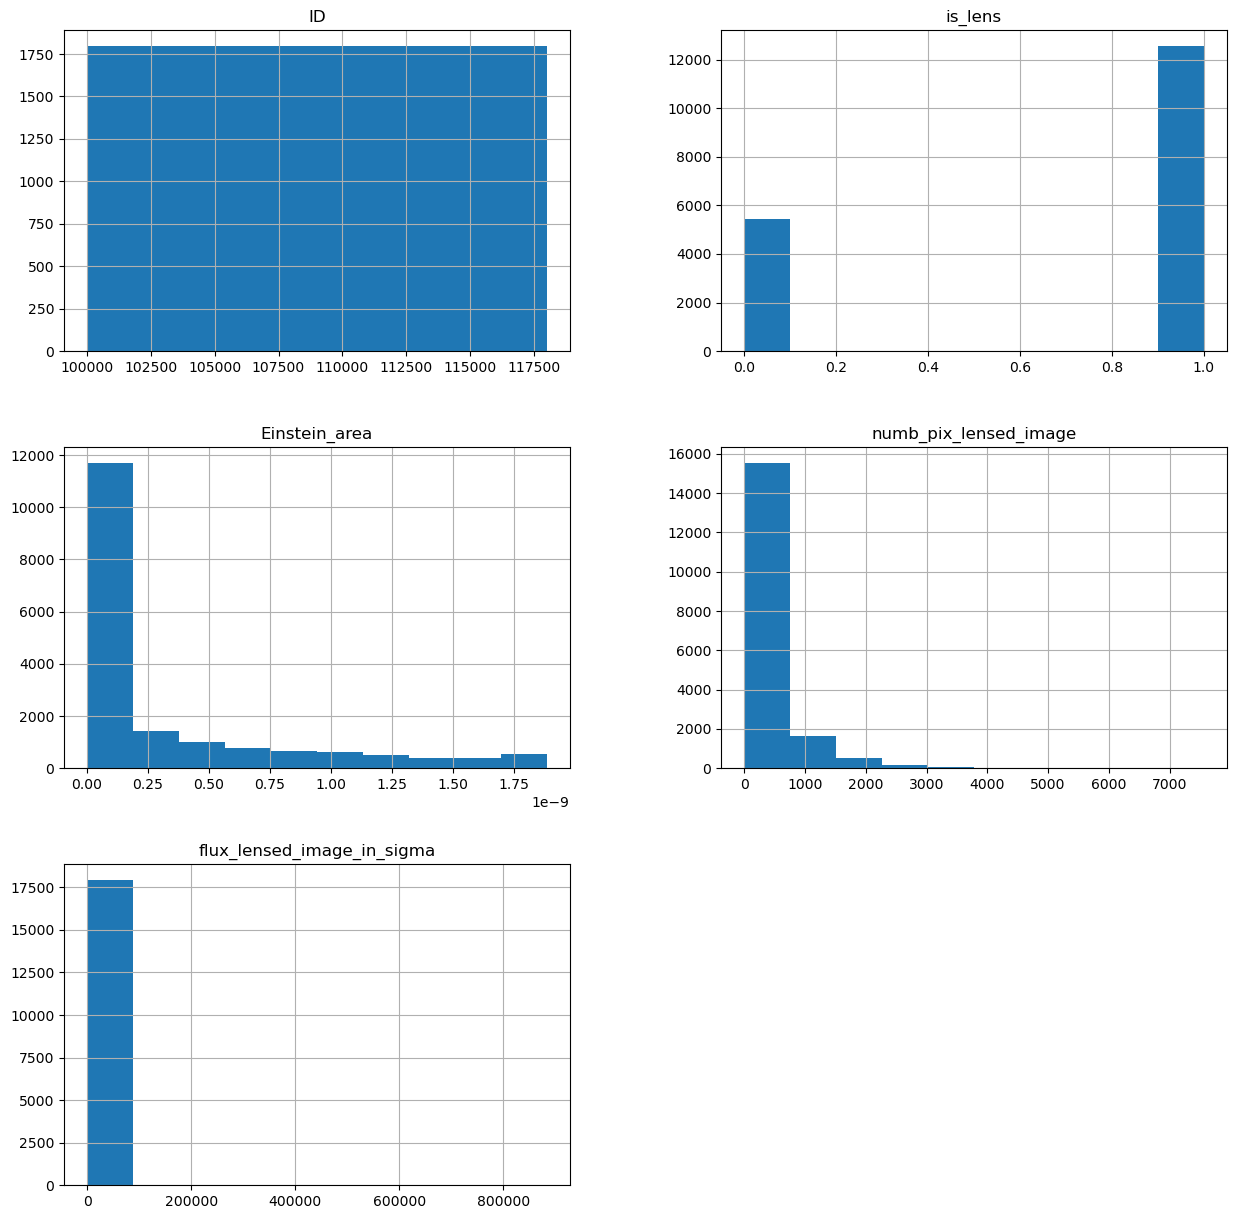

In [14]:
lis.hist(figsize=(15,15))
plt.show()

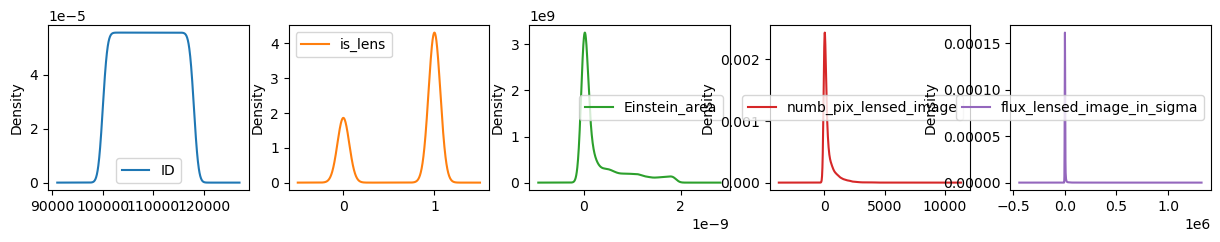

In [15]:
lis.plot(kind="density", layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15))
plt.show()

In [16]:
lis['numb_pix_lensed_image'] == 0

0        False
1        False
2        False
3        False
4         True
         ...  
17995    False
17996     True
17997    False
17998    False
17999    False
Name: numb_pix_lensed_image, Length: 18000, dtype: bool

In [17]:
def draw_univariate_plot(dataset, rows, cols, plot_type):
    column_names=dataset.columns.values
    number_of_column=len(column_names)
    fig, axarr=plt.subplots(rows,cols, figsize=(30,35))

    counter=0
    
    for i in range(rows):
        for j in range(cols):

            if column_names[counter]=='target':
                break
            if 'violin' in plot_type:
                sns.violinplot(x='target', y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'box'in plot_type :
                #sns.boxplot(x='target', y=column_names[counter],data=dataset, ax=axarr[i][j])
                sns.boxplot(x=None, y=column_names[counter],data=dataset, ax=axarr[i][j])

            counter += 1
            if counter==(number_of_column-1,):
                break

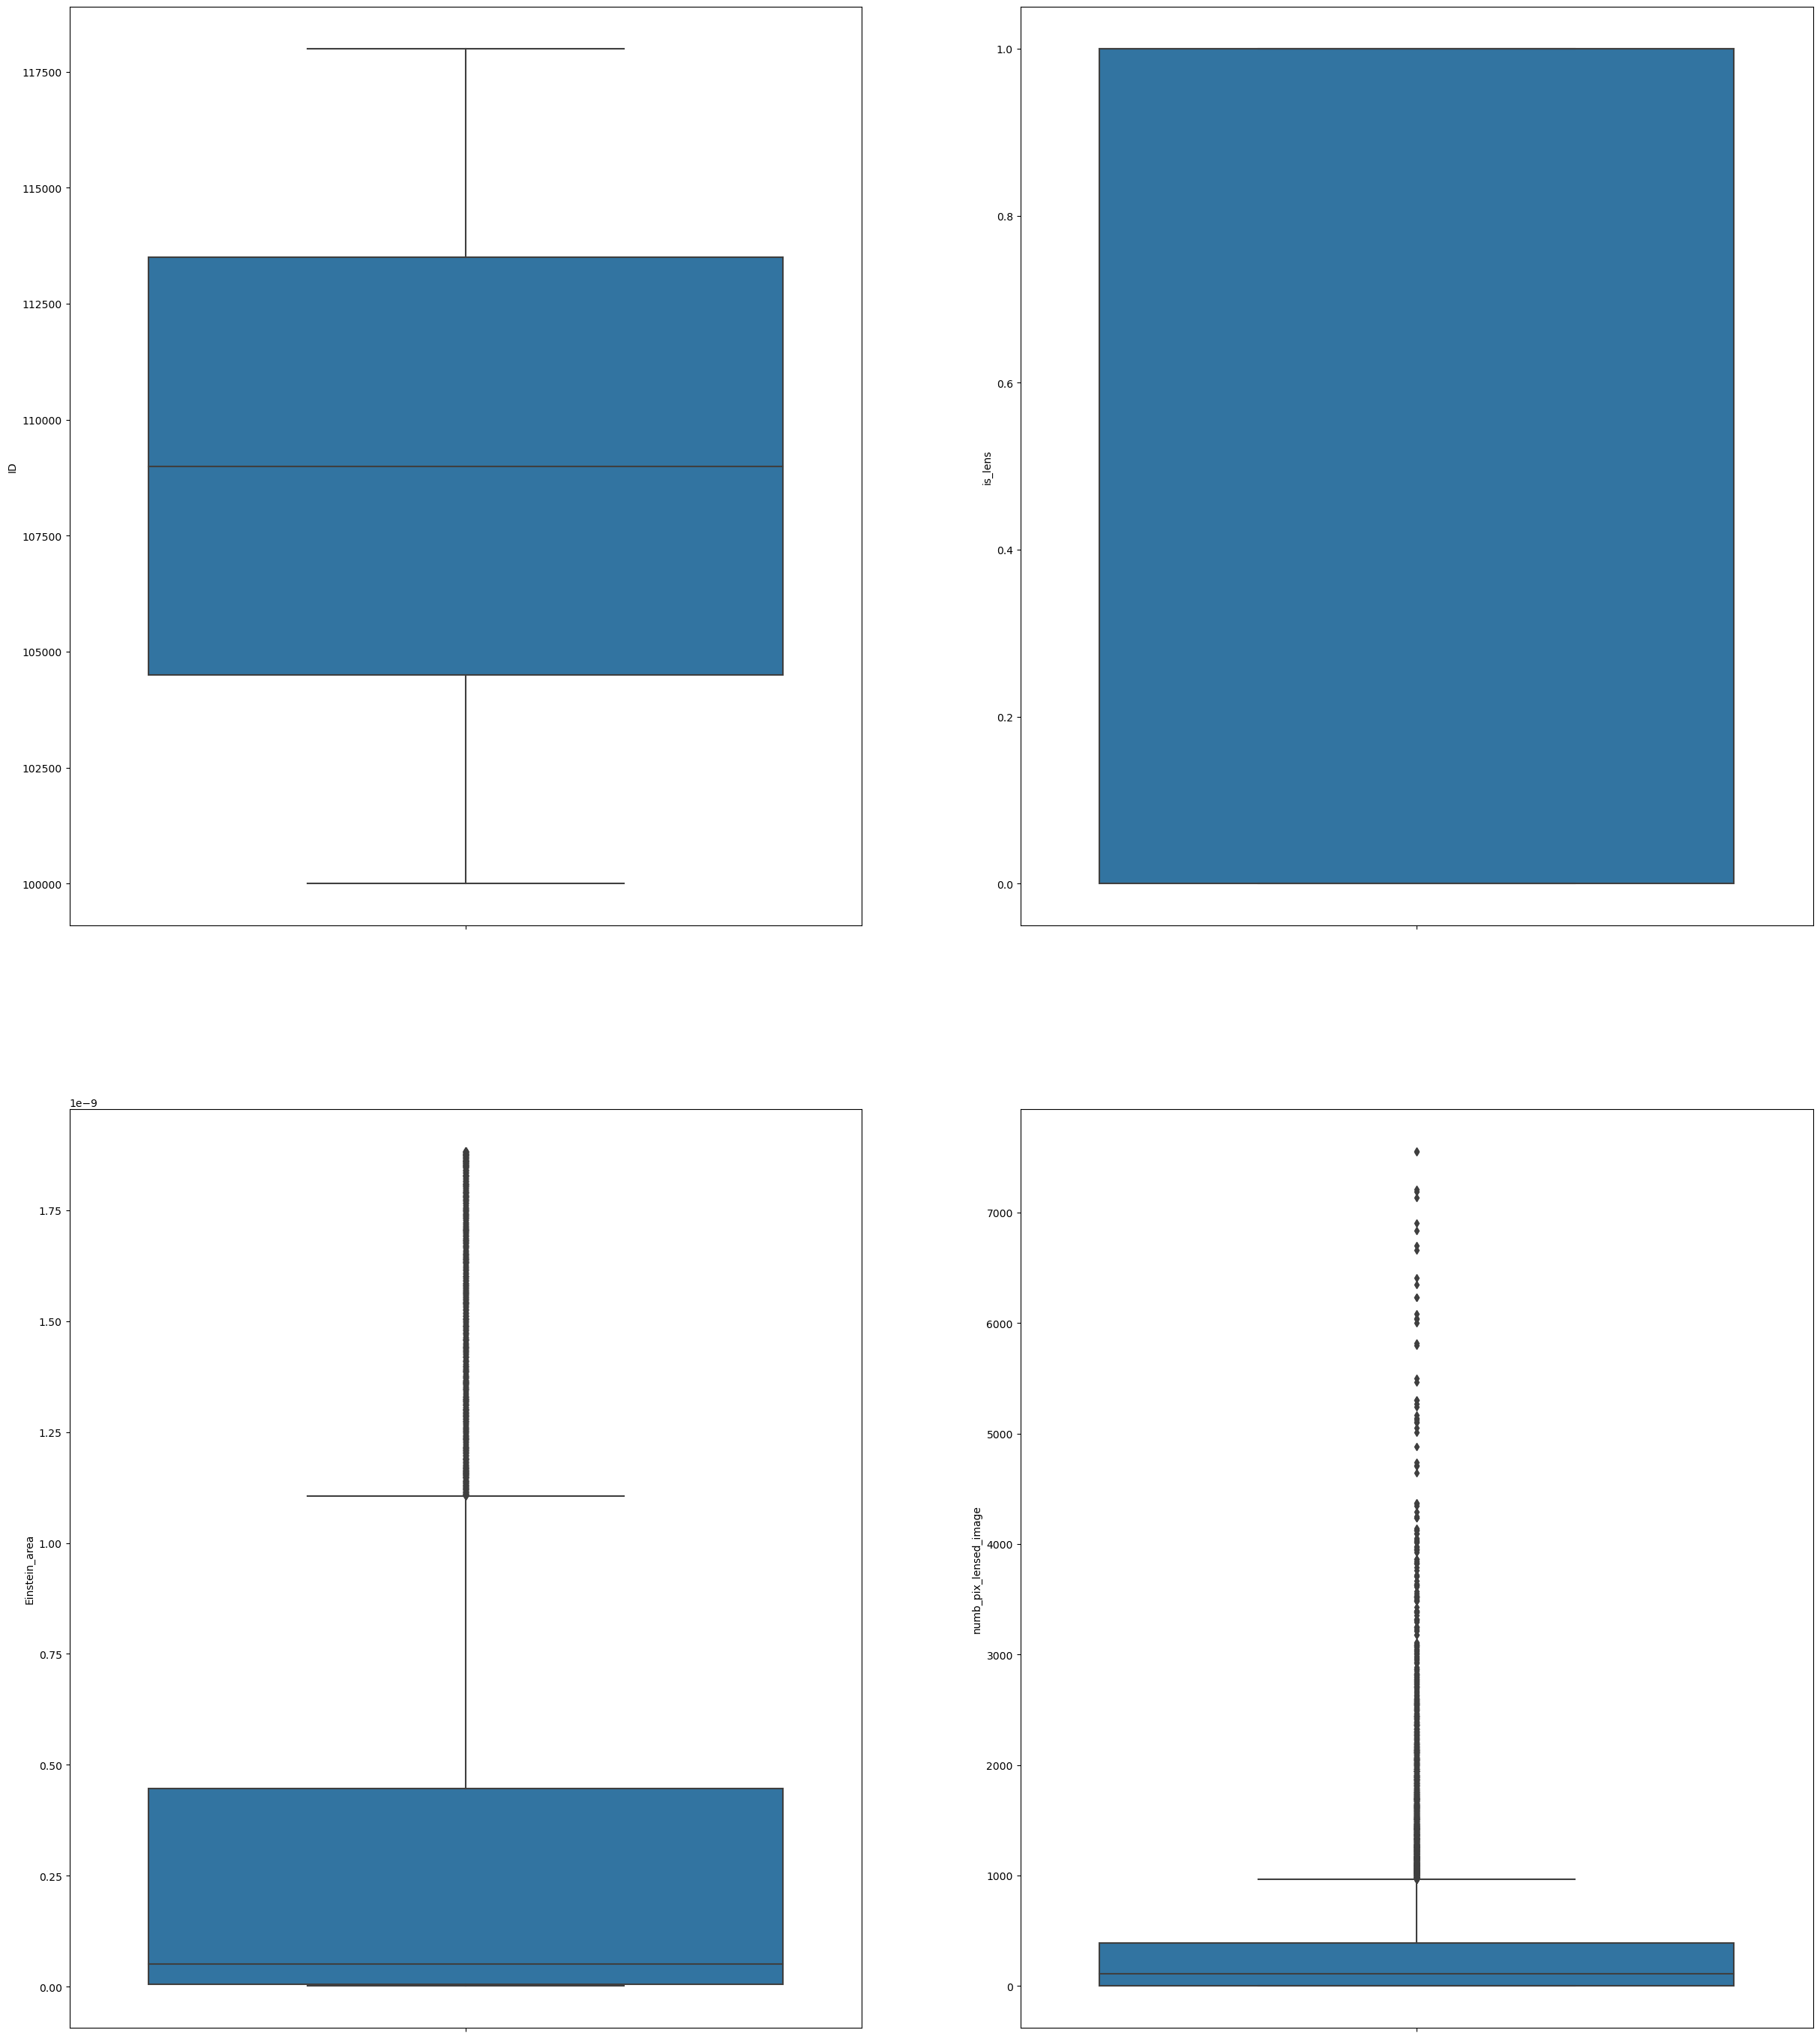

In [18]:
draw_univariate_plot(dataset=lis, rows=2, cols=2,plot_type="box")

In [19]:
def GetData(path):
    image_file = get_pkg_data_filename(path)
    image_data = fits.getdata(image_file, ext=0)
    return image_data

In [20]:
path = '/kaggle/input/lens-finding/SpaceBasedTraining/files/'

In [21]:
def modify(image):
    image = image.reshape((101,101,1))
    img = tf.reshape(tf.broadcast_to(image, (101, 101, 3)),  (101, 101, 3))
    image_data = tf.image.resize(np.array(img),[224,224])
    return image_data

In [22]:
lis.iloc[10:20]

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
10,100010,1,1.865290e-11,109,563.887
11,100011,1,1.896680e-10,557,1507.820
12,100012,0,1.349030e-11,0,0.000
13,100013,1,1.686280e-12,131,253.377
14,100014,1,8.325040e-11,542,2767.350
15,100015,0,1.630500e-10,0,0.000
16,100016,0,6.410460e-11,0,0.000
17,100017,0,1.596780e-10,0,0.000
18,100018,1,2.434730e-10,1472,4906.920
19,100019,1,1.516040e-09,336,1544.000


> # CUSTOM DATA GENERATOR
**Since Dataset was Large enough to handle , We need efficient way to take care of it.**
Notations
Before getting started, let's go through a few organizational tips that are particularly useful when dealing with large datasets.
Let ID be the Python string that identifies a given sample of the dataset. A good way to keep track of samples and their labels is to adopt the following framework:
> > 1.) Create a dictionary called partition where you gather:
> > > in partition['train'] a list of training IDs

> > > in partition['validation'] a list of validation IDs

> > 2.) Create a dictionary called labels where for each ID of the dataset, the associated label is given by labels[ID]

> First, let's write the initialization function of the class. We make the latter inherit the properties of keras.utils.Sequence so that we can leverage nice functionalities such as multiprocessing.

> We put as arguments relevant information about the data, such as dimension sizes (e.g. a volume of length 32 will have dim=(32,32,32)), number of channels, number of classes, batch size, or decide whether we want to shuffle our data at generation. We also store important information such as labels and the list of IDs that we wish to generate at each pass.

> Here, the method on_epoch_end is triggered once at the very beginning as well as at the end of each epoch. If the shuffle parameter is set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise).

> Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

> Another method that is core to the generation process is the one that achieves the most crucial job: producing batches of data. The private method in charge of this task is called __data_generation and takes as argument the list of IDs of the target batch.

> During data generation, this code reads the NumPy array of each example from its corresponding file ID.npy. Since our code is multicore-friendly, note that you can do more complex operations instead (e.g. computations from source files) without worrying that data generation becomes a bottleneck in the training process.

> Also, please note that we used Keras' keras.utils.to_categorical function to convert our numerical labels stored in y to a binary form (e.g. in a 6-class problem, the third label corresponds to [0 0 1 0 0 0]) suited for classification.

> Now comes the part where we build up all these components together. Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.

> A common practice is to set this value to
                ⌊#samples/batch size⌋
so that the model sees the training samples at most once per epoch.
Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.


In [23]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(150,150), n_channels=1,n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentor = ImageDataGenerator(
            rotation_range=90,
            width_shift_range=0.1,
            height_shift_range=0.1,
#             shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        Arr =[]
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
#             iD = ID.split('_')
#             print(ID)
            img = GetData(path+'imageEUC_VIS-'+ID+'.fits')
#             pth[i,] = (path+'imageEUC_VIS-'+ID+'.fits')
            image_data = np.asarray(img)
            image_data /= image_data.max()
            image_data = np.abs(image_data)
            img = modify(np.array(image_data))
            X[i,] = img
#             X[i,] = tf.image.resize(img, [self.dim[0], self.dim[1]])
#             data_augmentation.layers[0].adapt(X)
            y[i] = self.labels[ID]
        X_gen = self.augmentor.flow(X, batch_size=self.batch_size, shuffle=False)
        
        return next(X_gen), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [25]:
import random
from tqdm import tqdm
from sklearn.utils import shuffle
trains = []
train_labels = []
labels = {}
for k in tqdm(range(0,len(os.listdir(path)))):
    trains += [str(100000+k)]
    labels[str(100000+k)] = lis['is_lens'][k]

# print(labels[6225])
train = shuffle(trains)
train_data = train[:14400]
val_data = train[14400:18000]

100%|██████████| 18000/18000 [00:00<00:00, 145512.89it/s]


In [26]:
# val_data
partition = {'train': train_data , 'validation' : val_data}
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}


# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# MODEL

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = ResNet50(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Load the pre-trained weights you downloaded.
# pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [28]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
last_layer = pre_trained_model.get_layer('pool1_pad')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 114, 114, 64)


In [30]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(32, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (2,activation='softmax')(x)           

# Append the dense network to the base modeltmax
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)       0         
                                                                 
 conv1_conv (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 64)     256       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 112, 112, 64)      0         
                                                                 
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)      0         
                                                             

In [31]:
model.compile(optimizer = SGD(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = [tf.keras.metrics.AUC()])

In [32]:
history = model.fit(training_generator,epochs = 50, batch_size = 128,validation_data=validation_generator, verbose = 1)

Epoch 1/50
225/225 [==============================] - 626s 3s/step - loss: 0.6925 - auc: 0.6872 - val_loss: 0.6169 - val_auc: 0.6973
Epoch 2/50
225/225 [==============================] - 473s 2s/step - loss: 0.6281 - auc: 0.6896 - val_loss: 0.6155 - val_auc: 0.6987
Epoch 3/50
225/225 [==============================] - 470s 2s/step - loss: 0.6283 - auc: 0.6905 - val_loss: 0.6157 - val_auc: 0.6978
Epoch 4/50
225/225 [==============================] - 471s 2s/step - loss: 0.6275 - auc: 0.6930 - val_loss: 0.6157 - val_auc: 0.6975
Epoch 5/50
225/225 [==============================] - 472s 2s/step - loss: 0.6288 - auc: 0.6895 - val_loss: 0.6157 - val_auc: 0.6987
Epoch 6/50
225/225 [==============================] - 473s 2s/step - loss: 0.6272 - auc: 0.6916 - val_loss: 0.6146 - val_auc: 0.6978
Epoch 7/50
225/225 [==============================] - 521s 2s/step - loss: 0.6300 - auc: 0.6857 - val_loss: 0.6150 - val_auc: 0.6984
Epoch 8/50
225/225 [==============================] - 475s 2s/step - 

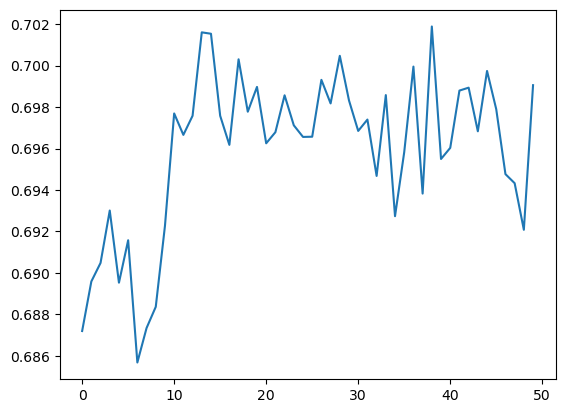

In [33]:
plt.plot(history.history['auc'])

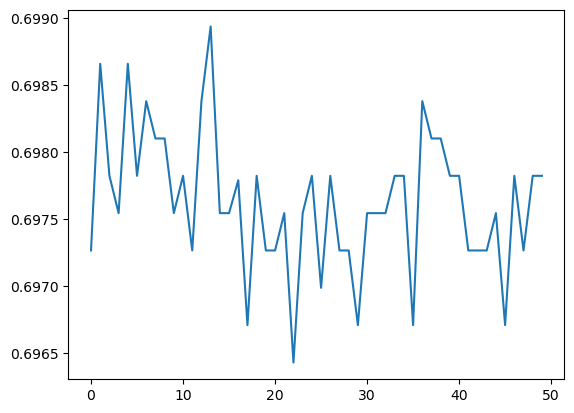

In [34]:
plt.plot(history.history['val_auc'])

In [35]:
model.save('modelLens.h5')